# Build and pretrain the GPT2 model

This is a practice notebook I wrote after I have read the book 'Build a large labguage model(from scratch)' by Sebastian Reschka. Most of the implementations of codes are from the book.

## Build the GPT2 model architecture

### Build the model architecture

In [1]:
from importlib.metadata import version

import torch
import torch.nn as nn
import torch.nn.functional as F
# a fast BPE tokenizer for use with openai's model
import tiktoken

from torch.utils.data import Dataset, DataLoader

import os
import urllib.request

print("torch version:", version("torch"))
print("tiktoken version:", version("tiktoken"))

torch version: 2.2.2
tiktoken version: 0.8.0


In [2]:
#define the whole GPT2 model
class GPT2Model(nn.Module):
    #initialize the class with configuration
    def __init__(self,conf):
        super().__init__()
        #define a token embedding which is a look up table where each vocab
        #is embedded to size emb_size
        self.token_emb=nn.Embedding(conf['vocab_size'],conf['emb_dim'])
        #define a position embedding where each position with in context_len
        #is embedded to size emb_size
        self.pos_emb=nn.Embedding(conf['context_len'],conf['emb_dim'])
        #define the dropout layer
        self.dropout=nn.Dropout(p=conf['dropout'])
        #define transformer blocks
        self.trf_blocks=nn.Sequential(*[Trf_layer(conf) for _ in range(conf['n_layers'])])
        #define the final layer normalization apply to shape (batch_size,n_tokens,emb_dim)
        self.final_laynorm=Layernorm(conf['emb_dim'])
        #define the output linear layer to project emb_dim into vocab_size
        self.final_proj=nn.Linear(conf['emb_dim'],conf['vocab_size'],bias=False)

        
        
    def forward(self,x):
        #input x is of shape (batch_size, n_tokens) 
        batch_size,n_tokens=x.shape
        #whose values come from bytepair encoding in GPT2
        #embed each token of x into emb_dim dimensional vector
        #token_emb_x shape: (batch_size, n_tokens,emb_dim)
        token_emb_x=self.token_emb(x) 
        #position embedding of every position of x along dimension n_tokens
        #pos_emb_x shape: (n_tokens,emb_dim)
        pos_emb_x=self.pos_emb(torch.arange(n_tokens,device=x.device))
        #combine token and position embedding
        embbed_x=token_emb_x+pos_emb_x
        embbed_x=self.dropout(embbed_x)
        #pass through transformer layers
        trf_out=self.trf_blocks(embbed_x)
        #pass through the final layer normalization
        out=self.final_laynorm(trf_out)
        #pass throught the output linear layer
        logits=self.final_proj(out)
        return logits


        
#define the transformer layer which contains a multihead attention sublayer 
#and a position-wise feed forward sublayer 
class Trf_layer(nn.Module):
    def __init__(self,conf):
        super().__init__()
        self.att=Multiheadattention(emb_dim=conf['emb_dim'],
                                    d_out=conf['emb_dim'],
                                    n_heads=conf['n_heads'],
                                    context_len=conf['context_len'],
                                    dropout=conf['dropout'],
                                   qkv_bias=conf['qkv_bias'])
        self.ff=Feedforward(conf['emb_dim'])
        self.norm1=Layernorm(conf['emb_dim'])
        self.norm2=Layernorm(conf['emb_dim'])
        self.dropout=nn.Dropout(conf['dropout'])
        
        
    def forward(self,x):
        #define a skip connection for attention sublayer
        #define a pre layer normalization before the attention layer and the feed forward layer
        #which usually gives better training dynamics than the post layer norm after attention and feed forward
        #which used in the original transformer architectures
        ori=x
        x=self.norm1(x)
        x=self.att(x)
        x=self.dropout(x)
        x=x+ori

        #define a skip connection for feed forward sublayer
        ori=x
        x=self.norm2(x)
        x=self.ff(x)
        x=self.dropout(x)
        x=x+ori
        return x
        
        
#define a multihead attention sublayer
class Multiheadattention(nn.Module):
    def __init__(self,emb_dim,d_out,n_heads,context_len,dropout,qkv_bias=False):
        super().__init__()
        #emb_dim is the dimension of the token after token embedding
        #d_out is the dimension of a token after linear projection
        #ensure the last dimension of key,query and value is divisible by the number of heads so that we can split it later
        assert d_out%n_heads==0
        self.emb_dim=emb_dim
        self.d_out=d_out
        self.n_heads=n_heads
        self.head_dim=d_out//n_heads #use floor division to ensure result is of type int
        
        self.query_w=nn.Linear(emb_dim,d_out,bias=qkv_bias)
        self.key_w=nn.Linear(emb_dim,d_out,bias=qkv_bias)
        self.value_w=nn.Linear(emb_dim,d_out,bias=qkv_bias)
        #define a mask to be upper triangular positions with 1 and others 0
        self.mask_ori=torch.triu(torch.ones(context_len,context_len),diagonal=1)
        #register the tensor mask as a persistent buffer of nn.module so that 
        #it works as the model.parameters() except that it would not be trained by SGD
        #i.e, it would be included in model.state_dict() and would be moved together with the model to device
        self.register_buffer('mask',self.mask_ori)
        self.dropout=nn.Dropout(dropout)
        self.out_proj=nn.Linear(d_out,d_out,bias=qkv_bias)
                             
    def forward(self,x):#x:(batch_size,n_tokens,emb_dim)
        batch_size,n_tokens,emb_dim=x.shape
        
        #linear projection of x into query, key and value
        queries=self.query_w(x) #output:(batch_size,n_tokens,d_out)
        keys=self.key_w(x)
        values=self.value_w(x)

        #split the last dimension d_out into multiheads: n_heads*head_dim=d_out
        #(batch_size,n_tokens,d_out)-->(batch_size, n_tokens,self.n_heads,self.head_dim)
        queries=queries.view(batch_size, n_tokens,self.n_heads,self.head_dim)
        keys=keys.view(batch_size, n_tokens,self.n_heads,self.head_dim)
        values=values.view(batch_size, n_tokens,self.n_heads,self.head_dim)

        #reshape it to (batch_size,self.n_heads,n_tokens,self.head_dim)
        queries=queries.transpose(1,2)
        keys=keys.transpose(1,2)
        values=values.transpose(1,2)
        
        #do a scale dot product of queries and keys and use it as the weights of values
        att_scores=queries@keys.transpose(2,3)#(batch_size,self.n_heads,n_tokens,n_tokens)
        #convert the mask to boolean type and truncate it to n_tokens size
        mask=self.mask.bool()[:n_tokens,:n_tokens]
        #mask the att_scores where the mask ==True to be negative infinity
        att_scores.masked_fill_(mask, -torch.inf)
        #apply softmax to the last dimension of the att_scores and convert it to att_weights
        att_weights=torch.softmax(att_scores/torch.sqrt(torch.tensor(self.head_dim)), dim=-1)
        #apply dropout to attention weights
        att_weights=self.dropout(att_weights)

        out=att_weights@values #(batch_size,self.n_heads,n_tokens,self.head_dim)
        #concate all heads
        out=out.transpose(1,2)#(batch_size,n_tokens,self.n_heads,self.head_dim)
        #merge the last two dimmension
        #call .contiguous() before .view() to make a copy of tensor to ensure that its order
        #of elements the same as if it had been created from scratch with the same data
        #since we can only apply .view() to contiguous tensor and .view() would not copy the tensor but just change its meta data
        #or we can use .reshape() instead which will make a new copy of the tensor if it is not contiguous
        out=out.contiguous().view(batch_size,n_tokens,self.d_out)
        
        out=self.out_proj(out) #optional output_projection
        return out

#define the layer normalization to normalize the last dimension of the input
#i.e., for each token, make its embedded vector to be gaussian unit, i.e., to have mean 0, std 1
class Layernorm(nn.Module):
    def __init__(self,last_dim):
        super().__init__()
        #define a small constant to avoid division by zero
        self.eps=1e-5
        #define shift and scale as parameters to be trained to improve model performance
        #since it can happens that the original distribution is better than the normalized distribution
        #scale, shift can help us to move between the original distribution and normalized distribution
        self.scale=nn.Parameter(torch.ones(last_dim))
        self.shift=nn.Parameter(torch.zeros(last_dim))
        
    def forward(self,x):
        mean=x.mean(dim=-1,keepdim=True)
        #we use biased variance(denominator=n) to match the original implementation of GPT2 in tensorflow
        var=x.var(dim=-1,keepdim=True, unbiased=False)
        x=(x-mean)/torch.sqrt(var+self.eps)
        return self.scale*x+self.shift

#define Gelu activation layer which is similar with Relu but smooth, and its gradient is 
#non zero for the negative input
#we use a computationally cheaper approximation of Gele
class Gelu(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))
        

#define the feed forward layer which is composed of two linear layers and a Gelu activation layer
class Feedforward(nn.Module):
    def __init__(self,d_out):
        #d_out is the dimension of the last dimension of the output of attention sublayer
        #in gpt2 it is the same with the token embedding size emb_dim
        super().__init__()
        #expand the d_out to 4*d_out by the first linear layer to learn more representations
        #compress back to original dimension d_out by the second linear layer
        self.layers=nn.Sequential(nn.Linear(d_out,4*d_out),
                                  Gelu(),
                                  nn.Linear(4*d_out,d_out))
    def forward(self,x):
        return self.layers(x)
            

### Configure a small untrained 124M GPT2 model

In [3]:
conf_124M={'vocab_size':50257, # Vocabulary size
      'emb_dim':768, # Embedding dimension of token and position embedding
      'n_layers':12, # Number of transformer layers
      'n_heads':12, # Number of attention heads
      'dropout':0.1, # Dropout rate
      'context_len':1024, # Context length of the context window
      'qkv_bias':False # bias of the linear projection of Query-Key-Value
     }

#instantiate a model with the above configuration
gpt2_124m_model=GPT2Model(conf_124M)

In [4]:
#print all the parameters
#for name, param in gpt2_124m_model.named_parameters():
    #print(name,param.shape)

In [5]:
#the total number of parameters of the model
total_params=sum(p.numel() for p in gpt2_124m_model.parameters())
total_params
#since the original GPT2 model reuse the weight of the token embedding as 
#the weights for final output linear embedding, the actual number of gpt2 model is
total_params_gpt2=total_params-sum(p.numel() for p in gpt2_124m_model.final_proj.parameters())
print('The total number of parameters of gpt2_124m model is',total_params_gpt2)

The total number of parameters of gpt2_124m model is 124402944


In [6]:
# compute the memory requirement of the model
# assume the parameters of the model are of type float32 and are stored in 4 bytes
memory_bytes=total_params*4
# convert to megabytes
memory_mb=memory_bytes/(1024*1024)
print(f'The required memory of the model is {memory_mb:.2f} MB.')

The required memory of the model is 621.80 MB.


### Use the untrained model to generate words

In [7]:
def text_encode(text,tokenizer):
    '''a function to encode the text string into token ids and add a batch dimension'''
    encoded_tokens=tokenizer.encode(text,allowed_special={'<|endoftext|>'})
    #convert the list to tensor and .unsqueeze(0) add a batch dimension in the first dimension
    encoded_tensors=torch.tensor(encoded_tokens).unsqueeze(0)
    return encoded_tensors

def tokenids_decode(encoded_tokens,tokenizer):
    '''a function to decode the encoded tokens to text'''
    #encoded_tokens shape: (batch_size=1,n_tokens)
    #.squeeze(0) remove the first dimension if it is of size 1
    encoded_tokens=encoded_tokens.squeeze(0)
    #convert the tensor to list
    encoded_tokens=encoded_tokens.tolist()
    return tokenizer.decode(encoded_tokens)

In [8]:
#tokenize a sentence to try the model
s='Today is Friday,'

#use the gpt2 tokenizer
enc=tiktoken.get_encoding('gpt2')

encoded_tensors=text_encode(s,enc)
print(f'The input tokens is of size {encoded_tensors.shape}.')

The input tokens is of size torch.Size([1, 4]).


In [9]:
#define a function to pass text to model and generate outputs
def generate_tokens_greedy(encoded_tokens,model,n_generate,model_context_len):
    '''a function which input the encoded tokens tensor in shape (batch_size,n_tokens), 
    pass it to the model n_generate time to generate one token at a time. At each timestep, 
    use greedy decoding to choose the token with the highest probability as the next token. 
    Append the token to the input text and pass them to the model again.'''
    model.eval()
    for _ in range(n_generate):
        #take the last part of the tokens if it is out of the range of the context length of the model
        encoded_tokens=encoded_tokens[:,-model_context_len:]
        #use context manager to close the computation of gradient and save memory
        with torch.no_grad():
            logits=model(encoded_tokens) #logits shape:(batch_size, n_tokens, 50257)
        next_tokens=logits[:,-1,:] # (batch_size,50257) the newly generated token is the last token
        probs=torch.softmax(next_tokens,dim=-1) #apply softmax to get the probabilities
        next_ids=torch.argmax(probs,dim=-1,keepdim=True) #(batch_size,1)
        encoded_tokens=torch.cat((encoded_tokens,next_ids),dim=-1)#(batch_size,n_tokens+1)
    return encoded_tokens


In [10]:
#get the generated output from the model
out_tokens=generate_tokens_greedy(encoded_tensors,gpt2_124m_model,10,conf_124M['context_len'])
print(f'The shape of output tokens is {out_tokens.shape}.\n')
#decode the output tokens
out_text=tokenids_decode(out_tokens,enc)
print(f'The output text is \n{out_text}.')

The shape of output tokens is torch.Size([1, 14]).

The output text is 
Today is Friday,616 Leone ClausHUD Nine roles FPubi anal infringement.


## Pretrain the GPT2 model

Since we did not train the model, we can see from above that it generate garbage. Now we will pretrained the gpt2_124m_model.

In [11]:
#define the hyperparameters for pretrain
n_epochs=10
batch_size=2
learning_rate=5e-4

#define the model configuaration
conf_pretrain={'vocab_size':50257, # Vocabulary size
      'emb_dim':768, # Embedding dimension of token and position embedding
      'n_layers':12, # Number of transformer layers
      'n_heads':12, # Number of attention heads
      'dropout':0.1, # Dropout rate
      'context_len':256, # Context length of the context window, shorted it to facilitate training
      'qkv_bias':False # bias of the linear projection of Query-Key-Value
     }


### Build a dataset and dataloader for pretraining

In [12]:
#create a gpt2 dataset of input data and target data which are 
#obtained by truncating the corpus text into a list of list of length 'context_len' tokens; 
#the difference between starting position of the next tokens list and the current tokens list is 'stride'
#the target data are the next token of the input data, i.e., the input data shift right by 1

class gpt2dataset(Dataset):
    def __init__(self,text,tokenizer,context_len,stride):
        self.inputs=[]
        self.targets=[]
        text_ids=tokenizer.encode(text,allowed_special={"<|endoftext|>"})
        for i in range(0,len(text_ids)-context_len,stride):
            input_chunk=text_ids[i:i+context_len]
            target_chunk=text_ids[i+1:i+1+context_len]
            self.inputs.append(torch.tensor(input_chunk))
            self.targets.append(torch.tensor(target_chunk))
    
    def __len__(self):
        return len(self.inputs)
    def __getitem__(self,idx):
        return self.inputs[idx],self.targets[idx]

#define a function to create dataset and dataloader to load dataset as batches
def create_dataloader(text,context_len,stride,batch_size,
                      shuffle,drop_last,num_workers=0):
    #create data set
    enc=tiktoken.get_encoding('gpt2')
    dataset=gpt2dataset(text,enc,context_len,stride)
    #the return dataloader is an iterable which has the __iter__() method 
    #iter(dataloader) will call dataloader.__iter__() and return an iterator object
    #iterator object has __next__ method implemented
    #next(iterator) will call iterator.__next__ and return the current state
    #when iterator is exhausted, stopiteration error will be raise
    #for loop is equal to first call iter(iterable) and then call next(iterator) 
    #until stopiteration error raised
    dataloader=DataLoader(dataset,batch_size=batch_size, shuffle=shuffle, 
                          drop_last=drop_last, num_workers=num_workers)
    return dataloader

In [13]:
#download a short story The Verdict by Edith Wharton if necessary
file_path = "the-verdict.txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

#if no such file, download it
if not os.path.exists(file_path):
    with urllib.request.urlopen(url) as response:
        text_data = response.read().decode('utf-8')
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
#else read it
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()

In [14]:
text_len=len(text_data)
print(f'The length of the text is: {text_len}')
tokenizer=tiktoken.get_encoding('gpt2')
total_tokens=len(tokenizer.encode(text_data))
print(f'The number of tokens of the text is: {total_tokens}')

The length of the text is: 20479
The number of tokens of the text is: 5145


In [15]:
#take a look at the text
print(text_data[:1000])

I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no great surprise to me to hear that, in the height of his glory, he had dropped his painting, married a rich widow, and established himself in a villa on the Riviera. (Though I rather thought it would have been Rome or Florence.)

"The height of his glory"--that was what the women called it. I can hear Mrs. Gideon Thwing--his last Chicago sitter--deploring his unaccountable abdication. "Of course it's going to send the value of my picture 'way up; but I don't think of that, Mr. Rickham--the loss to Arrt is all I think of." The word, on Mrs. Thwing's lips, multiplied its _rs_ as though they were reflected in an endless vista of mirrors. And it was not only the Mrs. Thwings who mourned. Had not the exquisite Hermia Croft, at the last Grafton Gallery show, stopped me before Gisburn's "Moon-dancers" to say, with tears in her eyes: "We shall not look upon its like again"?

Well!--even through th

In [16]:
# create the training and validation dataloader for gpt2
train_ratio=0.8
split_idx=int(len(text_data)*train_ratio)
train_data=text_data[:split_idx]
val_data=text_data[split_idx:]
trainloader=create_dataloader(train_data,context_len=conf_pretrain['context_len'],
                              stride=conf_pretrain['context_len'],
                             batch_size=2,shuffle=True,drop_last=True,num_workers=0)
valloader=create_dataloader(val_data,context_len=conf_pretrain['context_len'],
                            stride=conf_pretrain['context_len'],
                             batch_size=2,shuffle=False,drop_last=False,num_workers=0)


In [17]:
#check that dataloaders are organized correctly
print('train_loader:')
print(len(trainloader))
for x,y in trainloader:
    print(x.shape,y.shape)
    
print('val loader:')
print(len(valloader))
for x,y in valloader:
    print(x.shape,y.shape)

train_loader:
8
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
val loader:
2
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])


### Pretrain the gpt2 model

In [18]:
#define the training loop
def train_loop(model,dataloader,loss_fn,optimizer,device,print_per=1):
    '''define the training loop and return the train loss average over all the batches'''
    #set the model to be in training mode to change the behavior of drop out and batch normalization
    model.train()
    #print(f'dataset is {dataloader.dataset}.')
    size=len(dataloader.dataset)
    total_loss=0
    #iterate over all the batches of the dataloader
    for batch_idx, (features,targets) in enumerate(dataloader):
        #device setting
        features=features.to(device)
        targets=targets.to(device)
        #clear out the accumulated gradients
        optimizer.zero_grad()
        logits=model(features)
        #compute the average loss over all samples of the current batch
        loss_batch_average=loss_fn(logits,targets)
        #back propagate the loss and compute the gradients for params with requires_grad=True
        loss_batch_average.backward()
        #update the params with the newly computed gradients according to the optimizer
        optimizer.step()
        #compute the total loss over all the batches
        loss=loss_batch_average.item()
        total_loss+=loss
        #print the loss every print_per batches
        if batch_idx % print_per==0:
            #print(batch_idx,batch_size,len(features),size)
            current_token = batch_idx * batch_size+len(features)
            print(f'Train loss for current batch {loss:>7f}, [{current_token:>5d}/{size:>5d}].')
        
    total_loss_average=total_loss/len(dataloader)
    return total_loss_average
    
        
#define the evaluation loop
def eval_loop(model,dataloader,loss_fn,device):
    '''define the validation loop and return the validation loss average all the batches'''
    #set the model to be in evaluation mode to change the behavior of drop out and batch normalization
    model.eval()
    n_batches=len(dataloader)
    loss_total=0
    #tell pytorch not to compute the gradients 
    with torch.no_grad():
        for features, targets in dataloader:
            features=features.to(device)
            targets=targets.to(device)
            logits=model(features)
            loss_batch_average=loss_fn(logits,targets)
            loss_total+=loss_batch_average.item()
    print(f'\nEvaluation loss for current epoch {loss_total:>7f}.')
    model.train()
    return loss_total

#define the loss function
def loss_fn_gpt2(logits_b,targets_b):
    '''define the loss function, reshape logits and targets to use the cross_entropy loss'''
    #reshape the logits and targets to use torch.nn.functional.corss_entropyloss
    #logits_b shape: (batch_size,n_tokens,vocab_size)
    #targets_b shape:(batch_size,n_tokens)
    #since F.cross_entropy expect input,target to be of shape (batch_size,n_classes) and (batch_size)
    #we thus need to flatten the logits_b and targets_b
    loss=F.cross_entropy(logits_b.flatten(0,1),targets_b.flatten())
    return loss
    
#define a function to generate text after start_text after epoch during training
def generate_and_print_sample(model,start_text,tokenizer,device,n_generate):
    '''tokenize start_text using tokenizer, move it to device,
    and pass it to model to generate n_generate new words'''
    model.eval()
    #tokenizer the start_text into tokens and move it to device
    encoded_tokens=text_encode(start_text,tokenizer).to(device)
    #encoded_tokens shape (batch_size=1, n_tokens)
    #get the context window size of the model
    model_context_len=model.pos_emb.weight.shape[0]
    #pass the token_ids to model to generate output 
    with torch.no_grad():
        out_tokens=generate_tokens_greedy(encoded_tokens,model,n_generate,model_context_len)
    #out_tokens shape (batch_size=1, n_tokens)
    #decode the output
    out_text=tokenids_decode(out_tokens,tokenizer)
    print(f'\nThe output text of the current epoch is:\n{out_text}.')
    #convert back the model to training mode
    model.train()

In [19]:
#instatiate the model
model=GPT2Model(conf_pretrain)

#define an optimizer for model training
optimizer=torch.optim.AdamW(model.parameters(),lr=learning_rate,weight_decay=0.1)

#move the model to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

#define a start text to use model to generate words to to visualize the effect of training
start_text='Today is Friday,'
#use the gpt2 tokenizer
tokenizer=tiktoken.get_encoding('gpt2')
#generate 20 words for visualization
n_generate=20

#save the training loss and validation loss for each epoch for later visulization
train_losses_epochs, val_losses_epochs=[],[]
for e in range(n_epochs):
    print(f'Epoch {e+1}\n--------------------------------------')
    train_loss=train_loop(model,trainloader,loss_fn_gpt2,optimizer,device,print_per=1)
    train_losses_epochs.append(train_loss)
    val_loss=eval_loop(model,valloader,loss_fn_gpt2,device)
    val_losses_epochs.append(val_loss)
    generate_and_print_sample(model,start_text,tokenizer,device,n_generate)
print('Finished!')
    

Epoch 1
--------------------------------------
Train loss for current batch 10.996353, [    2/   16].
Train loss for current batch 9.844820, [    4/   16].
Train loss for current batch 9.412277, [    6/   16].
Train loss for current batch 9.156552, [    8/   16].
Train loss for current batch 8.828124, [   10/   16].
Train loss for current batch 8.587851, [   12/   16].
Train loss for current batch 8.090243, [   14/   16].
Train loss for current batch 7.998214, [   16/   16].

Evaluation loss for current epoch 15.060107.

The output text of the current epoch is:
Today is Friday, the the the the the the the the the the the the, the the the the the the the.
Epoch 2
--------------------------------------
Train loss for current batch 7.039148, [    2/   16].
Train loss for current batch 7.109453, [    4/   16].
Train loss for current batch 6.568961, [    6/   16].
Train loss for current batch 6.472637, [    8/   16].
Train loss for current batch 6.335046, [   10/   16].
Train loss for curre

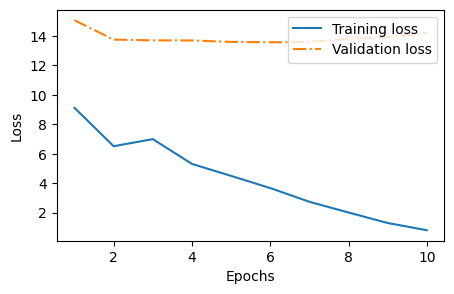

In [20]:
#define a function to plot the training losses and validation losses
import matplotlib.pyplot as plt

def plot_losses(epochs,train_losses,val_losses):
    fig,ax=plt.subplots(figsize=(5,3))
    ax.plot(epochs,train_losses,label='Training loss')
    ax.plot(epochs,val_losses,linestyle='-.',label='Validation loss')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend(loc='upper right')
    plt.show()

epochs=torch.arange(1,n_epochs+1)
plot_losses(epochs,train_losses_epochs, val_losses_epochs)
    

We can see from the graph that the validation loss does not decrease after the second epoch while the training loss is still decreasing. In addition, the validation loss is much larger than training loss, which signifies that the model is overfitting to the training data but does not generalize well to the validation data. This phenomenon is expected since compared to the number of parameters of our model, our training data set has only around 4000 tokens, whihc is very small. Thus our model is in fact memorizing the training text.

### Use top-k sampling and temperature scaling to adjust text generation

In the previous 'generate_tokens_greedy()' function, the way we generate text after we get the logits from the model is first apply the softmax function to turn the logits into probability and then use argmax function to choose the token with the highest probability as the next token. This process is deterministic in a way that if we pass the input text to the model again, the generated output text will always be the same. If we would like to add more diversity to our generated text we can modify the way we deal with the output logits.

One way is to use top-k sampling and temperature scaling. From the output logits of shape (batch_size, n_tokens, vocab_size) we take the last token batch which is of shape (batch_size, vocab_size). And then instead of applying the softmax function to the logits of all the vocabularies, we only retain the vocabularies with largest k probabilities and set the logits of other vacaularies to negative infinity. which means we would not sample from those vocabularies. Then we apply temperature scaling to

And then we apply the softmax function which converts the top-k vocabularies to its corresponding probabilities and other to probability 0, which means we would not sample from those vocabularies. Then we apply temperature scaling to the logits, i.e., we devide each logits by given temperature. after that we apply the softmax function to convert the logits to probailities. If the temperature >1, the distribution of the probabilities would be more uniform and if temperature <1, the distribution of the probability would be sharper. Finally we can apply the multinomal function to sample token according to the probability distribution instead of applying the argmax function to only sample the token with largest probability, which gives more diversity to the generated text.

In [21]:

def top_k_and_temperature(encoded_tokens,model,n_generate,model_context_len,top_k=None,
                          temperature=0):
    '''use the model for inference, input start_text to the model and get the output logits,
    apply top_k sampling to only choose the top_k highest tokens as condidates for next token,
    apply softmax to get the probabilities for the k candidates,
    scale the logits by temperature and sample from the scaled'''
    model.eval()
    for _ in range(n_generate):
        #only take the last part of encoded_ids within context len
        encoded_tokens=encoded_tokens[:,-model_context_len:]
        #print(encoded_tokens)
        with torch.no_grad():
            logits=model(encoded_tokens)
            #logits shape: (batch_size, n_tokens,vocab_size)
        #get the next tokens
        #next_tokens shape:(batch_size,vocab_size)
        next_tokens=logits[:,-1,:]
        if top_k is not None:
            values,indices=torch.topk(next_tokens,top_k)
            #values shape: (batch_size,top_k)
            #print(values.shape,indices.shape)
            #take the smallest value from the top k
            values_min=values[:,-1]
            #print('values_min:', values_min)
            #values_min shape: (batch_size,)
            #print(values_min.shape)
            #if the condition is satisfied, take values from input
            #otherwise, take input from other
            #mask the non top k values into -inf
            next_tokens=torch.where(
                condition=next_tokens<values_min,
                input=torch.tensor(float('-inf')).to(logits.device),
                other=next_tokens
            )
            #print('next_token shape:',next_tokens)
            #print('next_tokens:',(next_tokens!= torch.tensor(float('-inf'))).sum(dim=-1))
        #if we use temperature scaling, we divide the next_tokens by the temperature
        #and apply softamex to get the probability and use multinomial to sample from 
        #the probability, otherwise we use argmax to get the topen with max prob directly
        if temperature>0:
            next_tokens=next_tokens/temperature
            probs=torch.softmax(next_tokens,dim=-1)
            #for each row of probs, sample one sample from its probability distribution
            next_ids=torch.multinomial(probs,1)
            #print('next_ids',next_ids)
        else:
            next_ids=torch.argmax(next_tokens,dim=-1,keepdim=True)
        encoded_tokens=torch.cat((encoded_tokens,next_ids),dim=-1)
    return encoded_tokens
    

In [22]:
torch.manual_seed(222)
tokenizer=tiktoken.get_encoding('gpt2')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_generate=20
start_text='Today is Friday'
top_k=30
temperature=1.5
out_token_ids=top_k_and_temperature(text_encode(start_text,tokenizer),
                      model,n_generate,conf_pretrain['context_len'],
                      top_k,temperature)
print(f'Output text is: {tokenids_decode(out_token_ids,tokenizer)}.')


Output text is: Today is Friday, in ext of to have been too? You "Yes were like one of such an so dis.


## Save the pretrained model's parameters and the optimizer's parameters

In [23]:
#save the model parameters dictionary
torch.save(model.state_dict(),'model.pth')

#if we need to continue to train the model, we can also save the optimzer's parameters
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict':optimizer.state_dict()},
           'model_and_optimizer.pth')

In [24]:
#when we need to use the saved the model, we can first 
#instantiate the model using the same configurations
#and then load back the model parameters

#load back the parameters dictionary checkpoint
checkpoint=torch.load('model_and_optimizer.pth',map_location=device)
model_reloaded=GPT2Model(conf_pretrain)
model_reloaded.load_state_dict(checkpoint['model_state_dict'])

#if we need to continue training the model, we can load  back the optimizer's parameters
#instatiate the optimizer using the same configuration
optimizer=torch.optim.AdamW(model_reloaded.parameters(),lr=5e-4,weight_decay=0.1)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [25]:
!pwd

/Users/jialingyu/Documents/github_local/my_project_ML/build, pretrain and fine-tuned a large language model/Build and pretrain a gpt2 model
